# QGAN

Reference: https://qiskit.org/documentation/machine-learning/tutorials/04_torch_qgan.html

In [61]:
!pip install qiskit[machine-learning]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
!pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data and Representation

In [63]:
import torch
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123456
_ = torch.manual_seed(123456)  # suppress output

Big problem for QML on classical data is how to load that data into a quantum data. "QRAM", as its called, turns out to be computationally hard. This QGAN also addresses the problem of loading classical data into a quantum distribution.

In [64]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Next Steps
* increase the number of qubits to get the maximum number of qubits
* add a noise model
* Try the algorithm on a real processor

In [86]:
#discretize ??? likely for computational purposes
import numpy as np

num_dim = 2
num_discrete_values = 8
num_qubits = num_dim * int(np.log2(num_discrete_values))
print(f"{num_dim} {num_discrete_values} {num_qubits}")

2 8 4


In [87]:
# prepare discrete distribution from cts 2D normal dist.
from scipy.stats import multivariate_normal

coords = np.linspace(-2, 2, num_discrete_values) # 8 evenly spread out datapoints in the interval [-2,2] # why [-2,2]????
rv = multivariate_normal(mean=[0.0,0.0], cov=[[1,0],[0,1]], seed=algorithm_globals.random_seed) # unit mv norm
grid_elements = np.transpose([np.tile(coords, len(coords)), np.repeat(coords, len(coords))]) 
#np.tile basically repeats the coords linspace len(coords) = 8 times in a 1D array
#np.repeat repeats each element of coords len(coords) times 
#combining the two gives us a 2d array of the form [[x1,y1], [x2,y2], ...] where each coord is evenly spaced out|
prob_data = rv.pdf(grid_elements)
prob_data /= np.sum(prob_data)

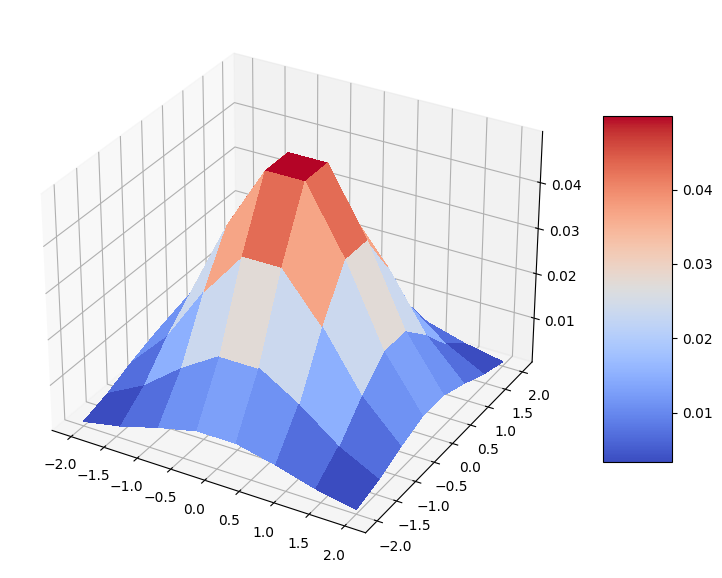

In [88]:
# visualize the distribution
import matplotlib.pyplot as plt
from matplotlib import cm

mesh_x, mesh_y = np.meshgrid(coords, coords)
grid_shape = (num_discrete_values, num_discrete_values)

fig, ax = plt.subplots(figsize=(9,9), subplot_kw={"projection": "3d"})
prob_grid = np.reshape(prob_data, grid_shape)
surf = ax.plot_surface(mesh_x, mesh_y, prob_grid, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Define Neural Networks

In [101]:
# define the quantum ansatz (generator)
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2

qc = QuantumCircuit(num_qubits)
qc.h(qc.qubits)

ansatz = EfficientSU2(num_qubits, reps=6) # this might need to be replaced to follow the paper
qc.compose(ansatz, inplace=True)

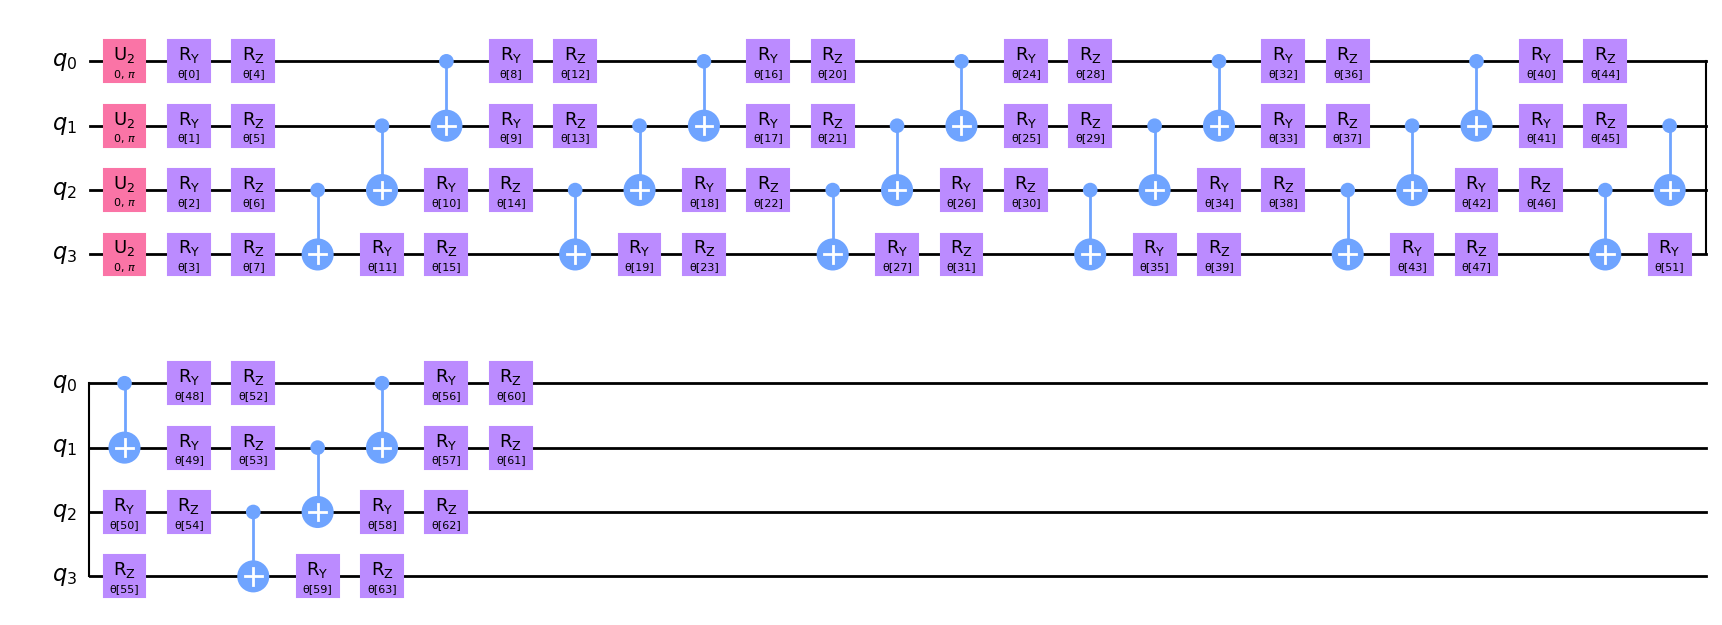

In [102]:
qc.decompose().draw("mpl")

In [103]:
qc.num_parameters

64

In [104]:
# sampler for sampling from the distribution
from qiskit.primitives import Sampler

shots = 10000
sampler = Sampler(options={"shots": shots, "seed": algorithm_globals.random_seed})

In [111]:
from qiskit_machine_learning.connectors import TorchConnector #for Pytorch-based training since we're also using a classical discriminator
from qiskit_machine_learning.neural_networks import SamplerQNN #neural network that takes in a parametrized quantum circuit with designated parameters for input data and/or weights and translates the quasi-probabilities estimated by the Sampler primitive into predicted classes. 
'''
  # ok so by default the output dimension of this shit is 2**num_qubits
  # you can change this by definining an interpret function, which is 
  A callable that maps the measured integer to another unsigned integer or tuple of unsigned integers. These are used as new indices for the (potentially
                sparse) output array. If no interpret function is
                passed, then an identity function will be used by this neural network.

                what the fuck does that even mean

                wait is it because the measurement is n qubits where each qubit has 2 measurement outcomes -> 2^n combinations?
'''
def create_generator() -> TorchConnector:
  qnn = SamplerQNN(
      circuit=qc,
      sampler=sampler,
      input_params=[],
      weight_params=qc.parameters,
      sparse=False,
  )

  initial_weights = algorithm_globals.random.random(qc.num_parameters)
  return TorchConnector(qnn, initial_weights)

IndentationError: ignored

In [94]:
# define classical discriminator
from torch import nn

class Discriminator(nn.Module):
  def __init__(self, input_size):
    super(Discriminator, self).__init__()

    self.linear_input = nn.Linear(input_size, 20)
    self.leaky_relu = nn.LeakyReLU(0.2)
    self.linear20 = nn.Linear(20, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input: torch.Tensor) -> torch.Tensor:
    x = self.linear_input(input)
    x = self.leaky_relu(x)
    x = self.linear20(x)
    x = self.sigmoid(x)
    return x

In [106]:
#create generator + discriminator
generator = create_generator()
discriminator = Discriminator(num_dim)

# Training
We use BCE loss for both the generator and the discriminator.

In [107]:
# Pytorch BCE isn't differentiable wrt weights???? so we define our own I'm pretty sure it is though??
def adversarial_loss(input, target, w):
  bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
  weighted_loss = w * bce_loss
  total_loss = -torch.sum(weighted_loss)
  return total_loss

In [108]:
#optimizers
from torch.optim import Adam

lr = 0.01
b1 = 0.7 # first momentum
b2 = 0.999 # second momentum

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)
discriminator_optimizer = Adam(discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)

In [109]:
#visualize training process
from IPython.display import clear_output

def plot_training_progress():
  # we don't plot if we don't have enough data
  if len(generator_loss_values) < 2:
      return

  clear_output(wait=True)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

  # Generator Loss
  ax1.set_title("Loss")
  ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
  ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
  ax1.legend(loc="best")
  ax1.set_xlabel("Iteration")
  ax1.set_ylabel("Loss")
  ax1.grid()

  # Relative Entropy
  ax2.set_title("Relative entropy")
  ax2.plot(entropy_values)
  ax2.set_xlabel("Iteration")
  ax2.set_ylabel("Relative entropy")
  ax2.grid()

  plt.show()

In [110]:
#training loop
import time
from scipy.stats import multivariate_normal, entropy

n_epochs = 50

num_qnn_outputs = num_discrete_values**num_dim # not too sure how the math worked out here

generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

start = time.time()
for epoch in range(n_epochs):

  valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)
  fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)

  #Configure input
  real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)

  #Configure samples
  samples = torch.tensor(grid_elements, dtype=torch.float)
  disc_value = discriminator(samples) #idk why we're feeding it the grid coords themselves
  print(f"disc out shape: {disc_value.shape}")

  #Generate data
  gen_dist = generator(torch.tensor([])).reshape(-1, 1)
  print(f"gen out shape: {gen_dist.shape}")

  #Train generator
  generator_optimizer.zero_grad()
  generator_loss = adversarial_loss(disc_value, valid, gen_dist) # we give it the generated distribution, discriminator's judgememts, and why do we give it a tensor full of ones???

  #store for plotting
  generator_loss_values.append(generator_loss.detach().item())

  generator_loss.backward(retain_graph=True)
  generator_optimizer.step()

  #Train Discriminator
  discriminator_optimizer.zero_grad()

  real_loss = adversarial_loss(disc_value, valid, real_dist) #wait why do we feed disc_value to all the losses??
  fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach())
  discriminator_loss = (real_loss + fake_loss) / 2

  #store for plotting
  discriminator_loss_values.append(discriminator_loss.detach().item())

  discriminator_loss.backward()
  discriminator_optimizer.step()

  entropy_value = entropy(gen_dist.detach().squeeze().numpy(), prob_data) # RELATIVE ENTROPY
  entropy_values.append(entropy_value)

  plot_training_progress()

elapsed = time.time() - start
print(f"Fit in {elapsed:2f} sec")

disc out shape: torch.Size([64, 1])
gen out shape: torch.Size([16, 1])


RuntimeError: ignored

In [ ]:
# SAVE MODEL
PATH = "./gdrive/MyDrive/QGAN" # CHANGE THIS TO A PROPER LOCATION

torch.save({
            'epoch': epoch,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': generator_optimizer.state_dict(),
            'loss': generator_loss,
            'relative_entropies': entropy_values
            }, f"{PATH}/{num_qubits}-bit_generator.pt")

torch.save({
            'epoch': epoch,
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': discriminator_optimizer.state_dict(),
            'loss': discriminator_loss,
            }, f"{PATH}/{num_qubits}-bit_discriminator.pt")

In [ ]:
## LOAD MODEL TODO ADD DISCRMINIATOR CODE

# generator = create_generator()
# generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)

# checkpoint = torch.load(PATH)
# generator.load_state_dict(checkpoint['model_state_dict'])
# generator_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# generator_loss = checkpoint['loss']

# model.eval()
# # - or -
# model.train()

# Inference / Validation

In [ ]:
#compare the CDF of the trained distributino to the CDF of the target distribution
with torch.no_grad():
  generated_probabilities = generator().numpy()

In [ ]:
fig = plt.figure(figsize=(18, 9))

# Generated CDF
gen_prob_grid = np.reshape(np.cumsum(generated_probabilities), grid_shape)

ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax1.set_title("Generated CDF")
ax1.plot_surface(mesh_x, mesh_y, gen_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax1.set_zlim(-0.05, 1.05)

# Real CDF
real_prob_grid = np.reshape(np.cumsum(prob_data), grid_shape)

ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax2.set_title("True CDF")
ax2.plot_surface(mesh_x, mesh_y, real_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax2.set_zlim(-0.05, 1.05)

# Difference
ax3 = fig.add_subplot(1, 3, 3, projection="3d")
ax3.set_title("Difference between CDFs")
ax3.plot_surface(
    mesh_x, mesh_y, real_prob_grid - gen_prob_grid, linewidth=2, antialiased=False, cmap=cm.coolwarm
)
ax3.set_zlim(-0.05, 0.1)
plt.show()

KL divergence, also known as relative entropy, is a measure of how "different" a probability distribution P is from a reference probability distribution Q. The equation is $$D_{KL}(P || Q) = \sum_{x \in χ} P(x)log(\frac{P(x)}{Q(x)})$$. In English, this is the expected value of log difference between the probabilities.

We've actually already calculated the relative entropy earlier in the training loop, so we're going to use that.

In [ ]:
print(entropy_values[-1])

In [ ]:
#TODO: find a more elegant way to compare the relative entropies of different hyperparams (num qubits, noise model etc.)